In [1]:
from collections import defaultdict
from scipy.spatial.distance import squareform, pdist
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

# custom seaborn plot options to make the figures pretty
sns.set(color_codes=True, style='white', context='notebook', font_scale=1.25)
PALETTE = sns.color_palette("Set1")
sns.set_palette(PALETTE[3:])

import warnings
warnings.filterwarnings('ignore')

# Independence testing with restricted permutations

Here we show how the permutation tests of distance correlation (Dcorr) can be restricted to appropriately match known dependencies under the null distribution. Without such modifications, calculated pvalues are invalid as the permutation generated null distribution is incorrect.

In [2]:
from hyppo.independence import Dcorr

In [3]:
def simulate_2sample_null(n1, n2=None, d=100, group_std=0.1, seed=None):
    """
    Simulates a set of paired observations for a 2-sample test.
    
    n1,n2 : size of the two groups. Are both n1 if n2 is None
    d : dimension of observations
    group_std : standard deviation of normal distribution around group mean
    """
    np.random.seed(seed)
    
    # Means for each observation
    mus1 = np.random.normal(0,1,(n1,d))
    if n2 is not None:
        mus2 = np.random.normal(0,1,(n2,d))
    
    # Paired observations
    X = np.vstack(
        [np.random.normal(mu, group_std, (2,d)) for mu in mus1]  +
        [np.random.normal(mu, group_std, (2,d)) for mu in mus2]
    )        
    return X

In [4]:
# Simulation parameters
n1 = 25
n2 = 25
d = 100
group_std = 0.1

# Labels
Y_within = np.asarray([0, 1] * (n1 + n2))
Y_across = np.hstack(([0] * n1 * 2, [1] * n2 * 2))

# Permutation tree blocks
blocks_within = -1*np.hstack([[i+1]*2 for i in range(n1+n2)]).T
blocks_across = np.c_[
    np.hstack([[i+1]*2 for i in range(n1+n2)]),
    -1*Y_within - 1
]

# Test params
test_blocks = [None, None, blocks_within, blocks_across]
test_names = ['Unrestricted within', 'Unrestricted across', 'Restricted within', 'Restricted across']
test_Ys = [Y_within, Y_across, Y_within, Y_across]

## Permutation block examples

In order to restrict the permutations, we pass in a list of group labels. Each column is a list of labels which partitions the observations by shared label into blocks and multiple columns repeat this process recursively. At each level, blocks are exchangeable unless the label is a negative number, in which case it is fixed, and all elements of the final blocks are exchangeable. This defines the space of allowable permutations and the $Y$ matrix is permuted accordingly.

The block labels used in this notebook are visualized below, corresponding to data where observations are dependent within pairs. Because of the $Y$ values in our 2-sample testing case, block labels of $[1,1,2,2,...]$ would also have been allowable for both cases but would lead to unnecessary permutations being computed.

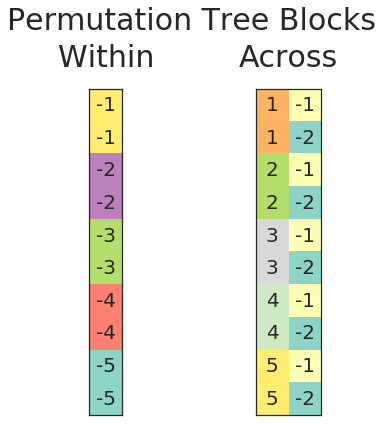

In [5]:
fig, axes = plt.subplots(1,2, figsize=(6,6))

for ax, data in zip(axes, (blocks_within[:,np.newaxis], blocks_across)):
    ax.matshow(data[:10], cmap='Set3')
    for (i, j), z in np.ndenumerate(data[:10]):
        ax.text(j, i, '{:}'.format(int(z)), ha='center', va='center', fontsize=20)
        ax.set_xticks([])
        ax.set_yticks([])
axes[0].set_title('Within', fontsize=30)
axes[1].set_title('Across', fontsize=30)
plt.suptitle('Permutation Tree Blocks', y=1.07, fontsize=30)
plt.show()

## Independence tests
As shown in the following figures, pvalues under unrestricted permutations are heavily skewed and certainly not uniform as one would want to be able to reject at a specified $\alpha$-level. When the permutations are restricted, the pvalues under the null distribution are empirically approximately uniformly distributed. 95% binomial proportion confidence interval error bars are displayed on the histogram of empirical pvalues for each bin.

In [6]:
N_DATASETS = 1000
REPS = 500
test_results = defaultdict(list)

In [7]:
for i in range(N_DATASETS):
    X = simulate_2sample_null(n1, n2, d, group_std, seed=i)
    for test, block, Y in zip(test_names, test_blocks, test_Ys):
        _, pval = Dcorr().test(
            X,Y,
            reps=REPS,
            workers=-1,
            perm_blocks=block,
        )
        test_results[test].append(pval)

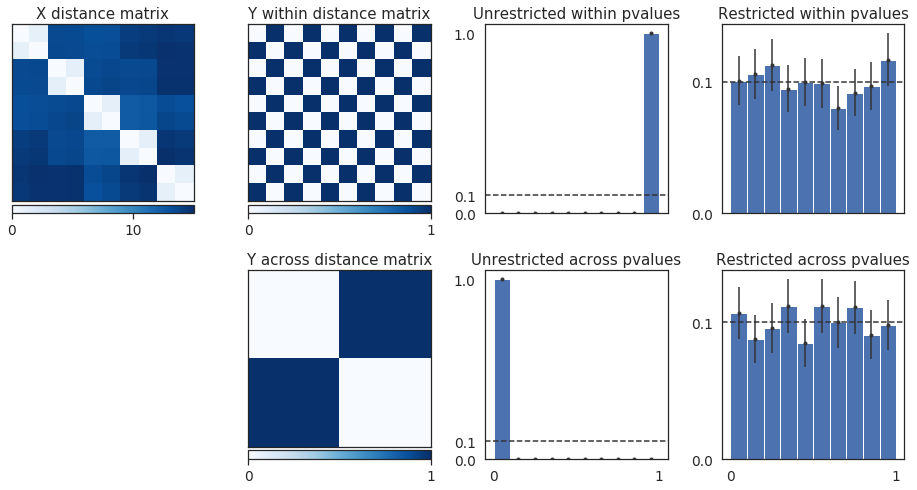

In [8]:
#fig, axes = plt.subplots(2,3, figsize=(4, 4*len(data_dict.keys())))
fig = plt.figure(figsize=(16, 8))

# Show data example
ax = fig.add_subplot(241)

X = simulate_2sample_null(n1, n2, d, group_std, seed=0)[:10,:]
X = squareform(pdist(X))
heatmap = ax.pcolor(X, cmap=plt.cm.Blues)
ax.invert_yaxis()
ax.xaxis.tick_top()
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('X distance matrix')

divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.05)
plt.colorbar(heatmap, cax=cax, ticks=[0, 10], orientation='horizontal')

# Plot Y matrices
ax = fig.add_subplot(242)
heatmap = ax.pcolor(squareform(pdist(Y_within[:10, np.newaxis])), cmap=plt.cm.Blues)
#ax.colorbar(heatmap)
ax.invert_yaxis()
ax.xaxis.tick_top()
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Y within distance matrix')

divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.05)
plt.colorbar(heatmap, cax=cax, ticks=[0, 1], orientation='horizontal')

ax = fig.add_subplot(246)
heatmap = ax.pcolor(squareform(pdist(np.hstack((Y_across[:5], Y_across[-5:]))[:, np.newaxis])), cmap=plt.cm.Blues)
#ax.colorbar(heatmap)
ax.invert_yaxis()
ax.xaxis.tick_top()
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Y across distance matrix')

divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.05)
plt.colorbar(heatmap, cax=cax, ticks=[0, 1], orientation='horizontal')

# Plot pvalue histograms and errorbars using binomial CIs
ax = None
for i,test_name in zip([3,7,4,8], test_names):
    ax = fig.add_subplot(int(str(f'24{i}')))#, sharey=ax)
    n = len(test_results[test_name])
    entries, edges, _ = ax.hist(test_results[test_name], bins = np.arange(0,1.1,0.1), weights=np.ones(n)/n, color='b')
    # entries = height of each column = proportion in that bin
    # calculate bin centers
    bin_centers = 0.5 * (edges[:-1] + edges[1:])
    ax.axhline(y=sum(entries) / len(bin_centers), ls='--', c='#333333')
    # errorbars are binomial proportion confidence intervals
    ax.errorbar(
        bin_centers, entries,
        yerr = 1.96 * np.sqrt(entries * (1 - entries) / n),
        fmt='.',c='#333333'
    )
    ax.set_title(f'{test_name} pvalues')
    #ax.set_xlim(0,1)
    if i in [3,4]:
        ax.set_xticks([])
    else:
        ax.set_xticks([0,1])
    if i in [4,8]:
        ax.set_yticks([0,0.1])
    else:
        ax.set_yticks([0, 0.1, 1])
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.show()